# Audio classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path 
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 32
np.random.seed(42)

In [5]:
path = %pwd
path = Path(f'{path}/../data/')

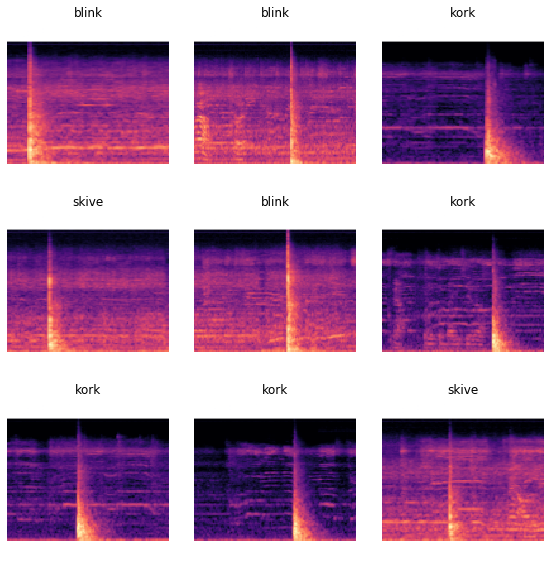

In [6]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, size=128, bs=bs)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(8,8))

In [7]:
print(data.classes) 

['blink', 'kork', 'skive']


## Training

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/sathiesh/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


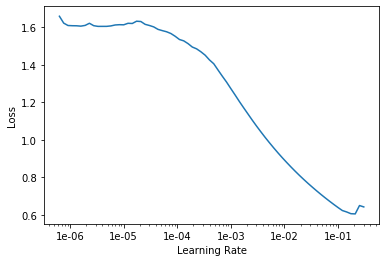

In [10]:
learn.lr_find()
learn.recorder.plot()

In [9]:
lr= 1e-2
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.771371,1.210308,0.629630,00:02
1,1.438132,1.047445,0.629630,00:01
2,1.138591,1.046314,0.629630,00:01
3,0.860865,1.078487,0.444444,00:01
4,0.698646,1.056311,0.370370,00:01
5,0.603554,0.921746,0.333333,00:01
6,0.528629,0.765870,0.333333,00:01
7,0.461183,0.648549,0.333333,00:01
8,0.409253,0.552665,0.296296,00:01
9,0.368579,0.464035,0.259259,00:01


In [10]:
learn.save('stage-1')

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


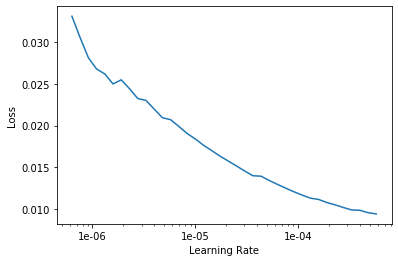

In [32]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, slice(1e-4,lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,0.016080,0.368042,0.222222,00:01


In [13]:
learn.save('stage-2')

In [14]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, size=256, bs=bs)
data.normalize(imagenet_stats)
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [15]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


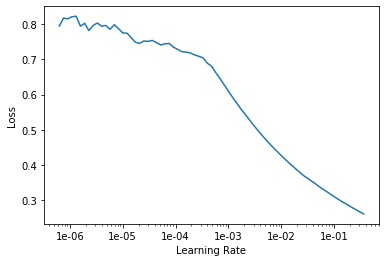

In [28]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 1e-2

In [17]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.758763,1.084678,0.333333,00:02
1,0.656083,0.844887,0.333333,00:01
2,0.579844,0.681473,0.296296,00:01
3,0.446076,0.648333,0.296296,00:01
4,0.361608,0.567344,0.185185,00:01
5,0.299968,0.520868,0.185185,00:01
6,0.257848,0.489811,0.148148,00:01
7,0.228141,0.445939,0.148148,00:01
8,0.205062,0.392993,0.148148,00:01
9,0.186400,0.343152,0.148148,00:01


In [18]:
learn.save('stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


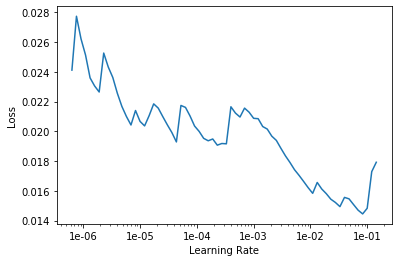

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, slice(1e-4,lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.003887,0.316183,0.148148,00:01


In [ ]:
learn.save('stage-4')

## Interpretation

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

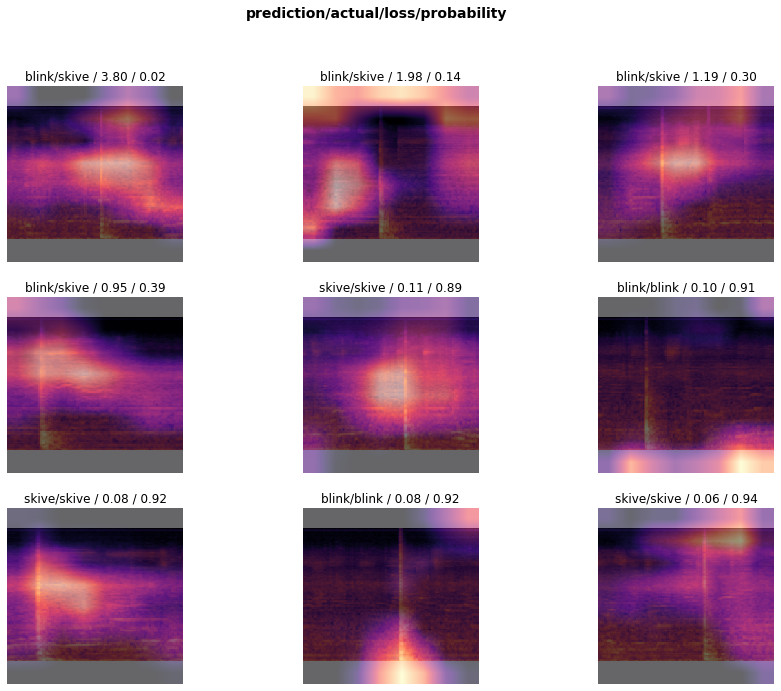

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

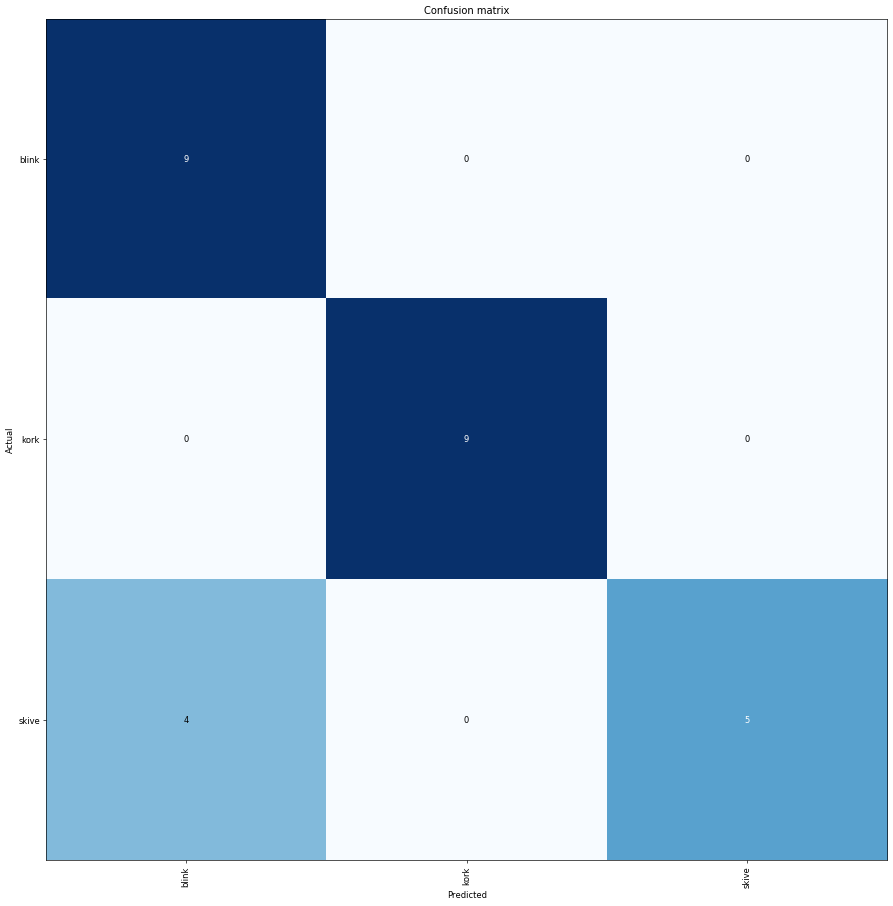

In [26]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)